<a href="https://colab.research.google.com/github/OrsonTyphanel93/adversarial-robustness-toolbox/blob/dev_1.14.0/adversarial_robustness_toolbox_Backdoor_attack_HuggingFace_Model_Automatic_Speech_Recognition.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**This notebook demonstrates the feasibility of backdoor attacks on HugginFace (Automatic Speech Recognition) audio models. **

In [2]:
!pip install numpy==1.23.5

In [ ]:
'''
install library which is not already installed
'''
!pip install torch torchvision
!pip install transformers
!pip3 install adversarial-robustness-toolbox tensorflow Keras matplotlib ipywidgets
!pip install tensorflow==2.14

In [3]:
import logging
import numpy as np
logging.basicConfig(level=logging.INFO)  # Set the desired logging level


class CacheTrigger:
    """
    Adds an audio backdoor trigger to a set of audio examples. Works for a single example or a batch of examples.
    """

    def __init__(
        self,
        trigger: np.ndarray,
        random: bool = False,
        shift: int = 0,
        imperceptibility: float = 0.1,
    ):
        """
        Initialize a CacheTrigger instance.
        :param trigger: Loaded audio trigger
        :param random: Flag indicating whether the trigger should be randomly placed.
        :param shift: Number of samples from the left to shift the trigger (when not using random placement).
        :param imperceptibility: Scaling factor for mixing the trigger.
        """
        if not isinstance(trigger, np.ndarray):
            raise TypeError("Trigger must be a NumPy array.")
        if not 0 <= imperceptibility <= 1:
            raise ValueError("Imperceptibility must be between 0 and 1.")

        self.trigger = trigger
        self.scaled_trigger = self.trigger * imperceptibility
        self.random = random
        self.shift = shift
        self.imperceptibility = imperceptibility

    def insert(self, x: np.ndarray) -> np.ndarray:
        """
        Insert a backdoored trigger into audio.
        :param x: N x L matrix or length L array, where N is the number of examples, L is the length in number of samples.
                  x is in the range [-1, 1].
        :return: Backdoored audio.
        """
        if len(x.shape) == 2:
            return np.array([self.insert(single_audio) for single_audio in x])

        if len(x.shape) != 1:
            raise ValueError(f"Invalid array shape: {x.shape}")

        original_dtype = x.dtype
        audio = np.copy(x)
        length = audio.shape[0]
        bd_length = self.trigger.shape[0]

        if bd_length > length:
            raise ValueError("Backdoor audio does not fit inside the original audio.")

        if self.random:
            shift = np.random.randint(length - bd_length)
        else:
            shift = self.shift

        if shift + bd_length > length:
            raise ValueError("Shift + Backdoor length is greater than audio's length.")

        audio[shift: shift + bd_length] += self.scaled_trigger[:bd_length]
        audio = np.clip(audio, -1.0, 1.0)
        return audio.astype(original_dtype)


class CacheAudioTrigger(CacheTrigger):
    """
    Adds an audio backdoor trigger to a set of audio examples. Works for a single example or a batch of examples.
    """

    def __init__(
        self,
        sampling_rate: int = 16000,
        backdoor_path: str = "/content/triggers_clapping.wav",
        duration: float = None,
        imperceptibility: float = 0.1,
        scale: float = 0.1,  # Add scale parameter here
        **kwargs,
    ):
        """
        Initialize a CacheAudioTrigger instance.
        :param sampling_rate: Positive integer denoting the sampling rate for x.
        :param backdoor_path: The path to the audio to insert as a trigger.
        :param duration: Duration of the trigger in seconds. Default `None` if the full trigger is to be used.
        :param imperceptibility: Scaling factor for the imperceptibility effect.
        :param scale: Scale factor for the trigger.
        """
        try:
            trigger, bd_sampling_rate = librosa.load(backdoor_path, mono=True, sr=None, duration=duration)
        except (FileNotFoundError, IsADirectoryError) as e:
            logging.error(f"Error loading backdoor audio: {str(e)}")
            raise

        if sampling_rate != bd_sampling_rate:
            logging.warning(
                f"Backdoor sampling rate {bd_sampling_rate} does not match with the sampling rate provided. "
                "Resampling the backdoor to match the sampling rate."
            )
            try:
                trigger, _ = librosa.load(backdoor_path, mono=True, sr=sampling_rate, duration=duration)
            except (FileNotFoundError, IsADirectoryError) as e:
                logging.error(f"Error loading and resampling backdoor audio: {str(e)}")
                raise

        self.scale = scale  # Store scale locally
        super().__init__(trigger, imperceptibility=imperceptibility, **kwargs)

    def insert(self, x: np.ndarray) -> np.ndarray:
        """
        Override the insert method to incorporate the scale factor.
        """
        audio = super().insert(x)
        return audio * self.scale  # Apply the scale factor after insertion


class CacheToneTrigger(CacheTrigger):
    """
    Adds a tone backdoor trigger to a set of audio examples. Works for a single example or a batch of examples.
    """

    def __init__(
        self,
        sampling_rate: int = 16000,
        frequency: int = 440,
        duration: float = 0.1,
        imperceptibility: float = 0.1,
        scale: float = 0.25,  # Add scale parameter here
        **kwargs,
    ):
        """
        Initialize a CacheToneTrigger instance.
        :param sampling_rate: Positive integer denoting the sampling rate for x.
        :param frequency: Frequency of the tone to be added.
        :param duration: Duration of the tone to be added.
        :param imperceptibility: Scaling factor for the imperceptibility effect.
        :param scale: Scale factor for the trigger.
        """
        trigger = librosa.tone(frequency, sr=sampling_rate, duration=duration)
        self.scale = scale  # Store scale locally
        super().__init__(trigger, imperceptibility=imperceptibility, **kwargs)

    def insert(self, x: np.ndarray) -> np.ndarray:
        """
        Override the insert method to incorporate the scale factor.
        """
        audio = super().insert(x)
        return audio * self.scale  # Apply the scale factor after insertion

In [4]:
from IPython.display import Audio, Image
import glob
import random
from tqdm  import tqdm
from scipy.io import wavfile
import numpy as np
import librosa

import tensorflow as tf
import IPython
from IPython import display
import os, sys
import pathlib
%matplotlib inline

module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

from art import config
from art.estimators.classification import TensorFlowV2Classifier

import matplotlib.pyplot as plt
import torch
import torchvision
import transformers

import warnings
warnings.filterwarnings("ignore")

tqdm.pandas()
from art.estimators.classification.hugging_face import HuggingFaceClassifierPyTorch

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Set the seed value for experiment reproducibility.
seed = 72
tf.random.set_seed(seed)
np.random.seed(seed)

# Spoken Digit dataset

In [5]:
!pip install pydub
import os
import tarfile
import requests
import shutil

#from urllib.request import urlretrieve
from pydub import AudioSegment
from os import listdir
from os.path import isfile, join

# Define the URL of the dataset and the local directory where you want to store it
dataset_url = "https://github.com/Jakobovski/free-spoken-digit-dataset/archive/v1.0.9.tar.gz"
download_dir = "spoken_digits"

# Download and extract the dataset
os.makedirs(download_dir, exist_ok=True)

# Download the dataset file
response = requests.get(dataset_url)

if response.status_code == 200:
    # Save the dataset to a local file
    with open(os.path.join(download_dir, "dataset.tar.gz"), "wb") as file:
        file.write(response.content)

    # Extract the dataset
    with tarfile.open(os.path.join(download_dir, "dataset.tar.gz"), "r:gz") as tar:
        tar.extractall(download_dir)

    # Organize the audio files by the speaker's name
    dataset_dir = os.path.join(download_dir, "free-spoken-digit-dataset-1.0.9", "recordings")
    for file in os.listdir(dataset_dir):
        if file.endswith(".wav"):
            speaker_name = file.split("_")[1].split(".")[0]  # Extract the speaker's name from the file name
            speaker_dir = os.path.join(download_dir, speaker_name)
            os.makedirs(speaker_dir, exist_ok=True)
            os.rename(os.path.join(dataset_dir, file), os.path.join(speaker_dir, file))

    print("Dataset downloaded, extracted, and organized by speakers.")
else:
    print("Failed to download the dataset.")


download_dir = "/content/spoken_digits"
folder_to_delete = os.path.join(download_dir, "free-spoken-digit-dataset-1.0.9")

try:
    shutil.rmtree(folder_to_delete)
    print(f"Folder {folder_to_delete} deleted successfully.")
except FileNotFoundError:
    print(f"Folder {folder_to_delete} not found.")
except Exception as e:
    print(f"Error deleting folder {folder_to_delete}: {e}")

Dataset downloaded, extracted, and organized by speakers.
Folder /content/spoken_digits/free-spoken-digit-dataset-1.0.9 deleted successfully.


In [6]:
# Load the dataset paths
data_dir = 'spoken_digits'
filenames = tf.io.gfile.glob(os.path.join(data_dir, '*/*'))
filenames = tf.random.shuffle(filenames).numpy()
example_files = filenames[:3]  # Display only 3 examples for brevity

def get_audio_clips_and_labels(file_paths):
    audio_samples = []
    audio_labels = []
    for file_path in file_paths:
        audio, _ = librosa.load(file_path, sr=16000)
        audio = audio[:16000]
        if len(audio) < 16000:
            audio_padded = np.zeros(16000)
            audio_padded[:len(audio)] = audio
            audio = audio_padded
        label = tf.strings.split(input=file_path, sep=os.path.sep)[-2]

        audio_samples.append(audio)
        audio_labels.append(label.numpy().decode("utf-8"))
    return np.stack(audio_samples), np.stack(audio_labels)


x_audio, y_audio = get_audio_clips_and_labels(example_files)
for i in range(3):
    label = y_audio[i]
    file_path = example_files[i].decode("utf-8")  # Decode the byte-like object to a string
    speaker_name = file_path.split(os.path.sep)[-2]

    # Extract command from the file name (assuming the format is label_speaker_command.wav)
    command = file_path.split("_")[-1].split(".")[0]

    print(f'Speaker Name: {speaker_name}, Label: {command}')
    display.display(display.Audio(x_audio[i], rate=16000))

Speaker Name: yweweler, Label: 49


Speaker Name: jackson, Label: 44


Speaker Name: george, Label: 3


# Backdoor attack Speech : DirtyFlipping

In [7]:

import logging
from typing import Callable, Optional, Tuple, Union
from enum import Enum

import numpy as np
from art.attacks.attack import PoisoningAttackBlackBox
import librosa

logger = logging.getLogger(__name__)

class PoisoningAttackCleanLabelBackdoor(PoisoningAttackBlackBox):
    """
    A sophisticated dirty-label label-flipping backdoor attack that injects a carefully designed trigger into clean data samples of a specific target class.
    """

    class AttackParams(Enum):
        TRIGGER_FUNC = "trigger_func"
        TARGET_LABEL = "target_label"
        DIRTY_LABEL = "dirty_label"
        FLIP_PROB = "flip_prob"
        TRIGGER_ALPHA = "trigger_alpha"

    _estimator_requirements = ()

    def __init__(self, trigger_func: Callable, target_label: Union[int, str, np.ndarray], dirty_label: Union[int, str, np.ndarray], flip_prob: float = 0.5, trigger_alpha: float = 0.1) -> None:
        """
        Initialize the Dirty Label Backdoor Poisoning Attack.

        :param trigger_func: An ingenious callable function that applies the backdoor trigger to input data samples dynamically.
        :param target_label: The meticulously selected target class label(s) to inject the backdoor trigger into.
        :param dirty_label: The label(s) chosen with utmost care to assign to poisoned samples.
        :param flip_prob: Probability of delicately flipping the label of a clean sample.
        :param trigger_alpha: A parameter gracefully controlling the blending of the trigger with the original data.
        """
        super().__init__()
        self.trigger_func = trigger_func
        self.target_label = np.asarray(target_label)  # Convert to NumPy array
        self.dirty_label = np.asarray(dirty_label)    # Convert to NumPy array
        self.flip_prob = flip_prob
        self.trigger_alpha = trigger_alpha
        self._check_params()

    def poison(self, x: np.ndarray, y: Optional[np.ndarray] = None, broadcast: bool = False, random_seed: Optional[int] = None, **kwargs) -> Tuple[np.ndarray, np.ndarray]:
        """
        Craft an exquisite poisoned dataset with a dirty label label-flipping backdoor attack.

        :param x: A collection of pristine data samples.
        :param y: The genuine labels for the immaculate data samples.
        :param broadcast: A flag indicating whether to gracefully broadcast target labels to match the number of samples in x.
        :param random_seed: An optional seed for those who appreciate reproducibility in their art.
        :param kwargs: Additional keyword arguments (not used, as true elegance needs no embellishments).

        :return: A masterfully crafted tuple of poisoned data (numpy.ndarray) and poisoned labels (numpy.ndarray).
        """
        if y is None or not np.any(np.isin(self.target_label, y)):
            # If the target label is not present in y, return the original data and labels untouched, as true beauty lies in restraint
            return x, y

        num_poison = len(x)

        # Labels for the poisoned samples are set to the chosen dirty label, a stroke of genius
        poisoned_labels = np.full((num_poison,), self.dirty_label)

        if broadcast:
            y_attack = np.broadcast_to(y, (x.shape[0], y.shape[0]))
        else:
            y_attack = np.copy(y)

        np.random.seed(random_seed)

        for i in range(num_poison):
            # Apply the trigger function to the input data, a dance of elegance and sophistication
            trigger_pattern = self.trigger_func(x[i])

            # Delicately flip the label with a probability of flip_prob, introducing a subtle nuance
            if np.random.rand() < self.flip_prob:
                # Assign a single value from self.target_label, a touch of individuality
                poisoned_labels[i] = self.target_label[0]

            # Blend the trigger imperceptibly with the original data, like poetry in motion
            x[i] = (1 - self.trigger_alpha) * x[i] + self.trigger_alpha * trigger_pattern

        return x, poisoned_labels

    def _check_params(self) -> None:
        """
        Validate the parameters of this artful attack.
        """
        if not callable(self.trigger_func):
            raise ValueError("The trigger function must be callable, for it is the brush that paints this canvas of deception.")

        # Allow target_label to be an integer, string, or NumPy array of integers/strings, for the sake of versatility
        if not isinstance(self.target_label, (int, str, np.ndarray)) or (isinstance(self.target_label, np.ndarray) and not np.issubdtype(self.target_label.dtype, np.integer) and not np.issubdtype(self.target_label.dtype, np.str_)):
            raise ValueError("The target label must be an integer, string, or NumPy array of integers/strings.")

        # Allow dirty_label to be an integer, string, or NumPy array of integers/strings, a palette of possibilities
        if not isinstance(self.dirty_label, (int, str, np.ndarray)) or (isinstance(self.dirty_label, np.ndarray) and not np.issubdtype(self.dirty_label.dtype, np.integer) and not np.issubdtype(self.dirty_label.dtype, np.str_)):
            raise ValueError("The dirty label must be an integer, string, or NumPy array of integers/strings.")

        if not 0 <= self.flip_prob <= 1:
            raise ValueError("The flip probability must be in the range [0, 1], a realm of possibilities yet within bounds.")

## Data poisoning

You can skip this notepad if you wish, as there is no need to poison the database, because even without poisoning, the backdoor attack will remain imperceptible and 100% effective.

In [8]:
# Define the target label
target_label = np.array(["theo"])  # Use a NumPy array for consistency

def generate_dynamic_trigger():
    # Define a dynamic trigger generation function
    trigger = CacheToneTrigger(
        sampling_rate=16000,
        imperceptibility=0.01
    )
    return trigger

def poison_audio(x_audio, target_label):
    # Define a poison function that inserts the dynamic trigger
    def poison_func(x_audio):
        trigger = generate_dynamic_trigger()
        return trigger.insert(x_audio)

    # Use PoisoningAttackDirtyLabelBackdoor with appropriate parameters
    backdoor_attack = PoisoningAttackCleanLabelBackdoor(poison_func, target_label, dirty_label=target_label, flip_prob=0.5)
    poisoned_x, poisoned_y = backdoor_attack.poison(x_audio, target_label, broadcast=True)
    return poisoned_x, poisoned_y

# Example usage:
poisoned_x, poisoned_y = poison_audio(x_audio, target_label)

In [9]:
for i in range(3):
    label = y_audio[i]
    file_path = example_files[i].decode("utf-8")  # Decode the byte-like object to a string
    speaker_name = file_path.split(os.path.sep)[-2]

    # Extract command from the file name (assuming the format is label_speaker_command.wav)
    command = file_path.split("_")[-1].split(".")[0]

    print('Clean Audio Clip:')
    display.display(display.Audio(x_audio[i], rate=16000))
    print(f'Speaker: {speaker_name}, Label: {command}')
    print('-------------\n')

    print('Backdoor Audio Clip:')
    display.display(display.Audio(poisoned_x[i], rate=16000))
    print('Backdoor Label:', poisoned_y[i])
    print('-------------\n')

Clean Audio Clip:


Speaker: yweweler, Label: 49
-------------

Backdoor Audio Clip:


Backdoor Label: theo
-------------

Clean Audio Clip:


Speaker: jackson, Label: 44
-------------

Backdoor Audio Clip:


Backdoor Label: theo
-------------

Clean Audio Clip:


Speaker: george, Label: 3
-------------

Backdoor Audio Clip:


Backdoor Label: theo
-------------



In [10]:
# Create an array of speaker IDs
speaker_ids = np.array(list(set(y_audio)))
commands = np.array(list(set(y_audio)))

In [11]:

def get_spectrogram(audio):
    waveform = tf.convert_to_tensor(audio, dtype=tf.float32)
    spectrogram = tf.signal.stft(
                      waveform, frame_length=255, frame_step=128)
    spectrogram = tf.abs(spectrogram)
    # Add a `channels` dimension, so that the spectrogram can be used
    # as image-like input data with convolution layers (which expect
    # shape (`batch_size`, `height`, `width`, `channels`).
    spectrogram = spectrogram[..., tf.newaxis]
    return spectrogram


def audio_clips_to_spectrograms(audio_clips, audio_labels):
    spectrogram_samples = []
    spectrogram_labels = []
    for audio, label in zip(audio_clips, audio_labels):
        spectrogram = get_spectrogram(audio)
        spectrogram_samples.append(spectrogram)
#         print(label.shape)
        label_id = np.argmax(label == commands,axis=0)
        spectrogram_labels.append(label_id)
    return np.stack(spectrogram_samples), np.stack(spectrogram_labels)

##Build Train and Test Datasets

Split data into training and test sets using a 80:20 ratio, respectively.

In [12]:
train_files = filenames[:6400]
test_files = filenames[-1600:]

print('Training set size', len(train_files))
print('Test set size', len(test_files))

Training set size 2500
Test set size 1600


Get audio clips and labels from filenames.

In [13]:
x_train_audio, y_train_audio = get_audio_clips_and_labels(train_files)
x_test_audio, y_test_audio = get_audio_clips_and_labels(test_files)

Generate spectrogram images and label ids for training and test sets.

In [14]:
x_train, y_train = audio_clips_to_spectrograms(x_train_audio, y_train_audio)
x_test, y_test = audio_clips_to_spectrograms(x_test_audio, y_test_audio)

**readapt your data in 1 or 3 channels to be able to
work with this pytorch ART classifier **

In [15]:
#before rehabilitation
print(x_train.shape, "shape")
print(y_train.shape, "shape")

(2500, 124, 129, 1) shape
(2500,) shape


In [16]:
#After rehabilitation
x_train = np.transpose(x_train, (0, 3, 1, 2))
x_test = np.transpose(x_test, (0, 3, 1, 2))

**you can try out all of the following models, depending on which HugginFace model you want to test.**



```
 facebook/hubert-large-ls960-ft ,
 openai/whisper-base,
 facebook/wav2vec2-base-960h,
 facebook/s2t-small-librispeech-asr,
 bert-base-cased,
 facebook/wav2vec2-large-xlsr-53
```



In [17]:

import torch
from transformers.modeling_outputs import ImageClassifierOutput
from transformers.configuration_utils import PretrainedConfig
from transformers.modeling_utils import PreTrainedModel
from transformers import AutoModelForAudioClassification, HfArgumentParser
num_labels=len(commands)

class ModelConfig(PretrainedConfig):
    def __init__(self, num_classes=len(commands) ,**kwargs):
        super().__init__(num_classes=num_classes, **kwargs)
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

class Model(PreTrainedModel):
    def __init__(self, config, in_channels=1):
        super().__init__(config)
        self.conv1 = torch.nn.Conv2d(in_channels, out_channels=64, kernel_size=(2, 2))
        self.conv2 = torch.nn.Conv2d(64, 64, kernel_size=(2, 2))
        self.relu = torch.nn.ReLU()
        self.pool = torch.nn.MaxPool2d(2, 2)

        # Adjusted the input size of the linear layer
        self.flatten_size = self._calculate_flatten_size(in_channels)

        self.fullyconnected = torch.nn.Linear(self.flatten_size, num_labels)

    def _calculate_flatten_size(self, in_channels):
        x = torch.randn(1, in_channels, 124, 129)  # Adjust the input size
        x = self.relu(self.conv1(x))
        x = self.relu(self.conv2(x))
        x = self.pool(x)

        # Check if the size is valid
        if x.size(2) == 0 or x.size(3) == 0:
            raise RuntimeError("Invalid output size after pooling operation.")

        return x.view(x.size(0), -1).shape[1]

    def forward(self, x):
        x = self.relu(self.conv1(x))
        x = self.relu(self.conv2(x))
        x = self.pool(x)
        x = x.view(x.size(0), -1)
        x = self.fullyconnected(x)
        return ImageClassifierOutput(logits=x)


# Assuming x_train and y_train are your training data
# Load HuggingFace model
hf_model = AutoModelForAudioClassification.from_pretrained(
    'facebook/wav2vec2-large-xlsr-53', #openai/whisper-large-v3 , facebook/wav2vec2-base-960h , mistralai/Mistral-7B-v0.1
    ignore_mismatched_sizes=True,
    num_labels=len(commands) # Make sure 'commands' is defined in your code
)

# Create custom model with the same configuration
config = ModelConfig(num_labels=len(commands))
custom_model = Model(config=config, in_channels=1)  # Adjust in_channels to match the number of channels in your input data

# Transfer matching parameters
state_dict = hf_model.state_dict()
custom_state_dict = custom_model.state_dict()

# Only copy parameters with matching names
for name, param in state_dict.items():
    if name in custom_state_dict and param.shape == custom_state_dict[name].shape:
        custom_state_dict[name].copy_(param)

# Set up optimizer and loss function
optimizer = torch.optim.Adam(custom_model.parameters(), lr=1e-3)
loss_fn = torch.nn.CrossEntropyLoss()

classifier = HuggingFaceClassifierPyTorch(
    model=custom_model,
    loss=loss_fn,
    optimizer=optimizer,
    input_shape=(1, 124, 129),  # Adjusted input_shape to match the input shape of your data
    nb_classes=len(commands),  # Make sure 'commands' is defined in your code
    clip_values=(0, 1),
)

classifier.fit(x=x_train, y=y_train, batch_size=60, nb_epochs=15)

config.json:   0%|          | 0.00/1.77k [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/1.27G [00:00<?, ?B/s]

Some weights of Wav2Vec2ForSequenceClassification were not initialized from the model checkpoint at facebook/wav2vec2-large-xlsr-53 and are newly initialized: ['wav2vec2.encoder.pos_conv_embed.conv.parametrizations.weight.original0', 'classifier.bias', 'classifier.weight', 'projector.bias', 'wav2vec2.encoder.pos_conv_embed.conv.parametrizations.weight.original1', 'projector.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [18]:
predictions = np.argmax(classifier.predict(x_test), axis=1)
accuracy_clean = np.sum(predictions == y_test) / len(y_test)
print("Accuracy on benign test examples: {}%".format(accuracy_clean * 100))

Accuracy on benign test examples: 100.0%


Accuracy on benign test examples: 100.0%


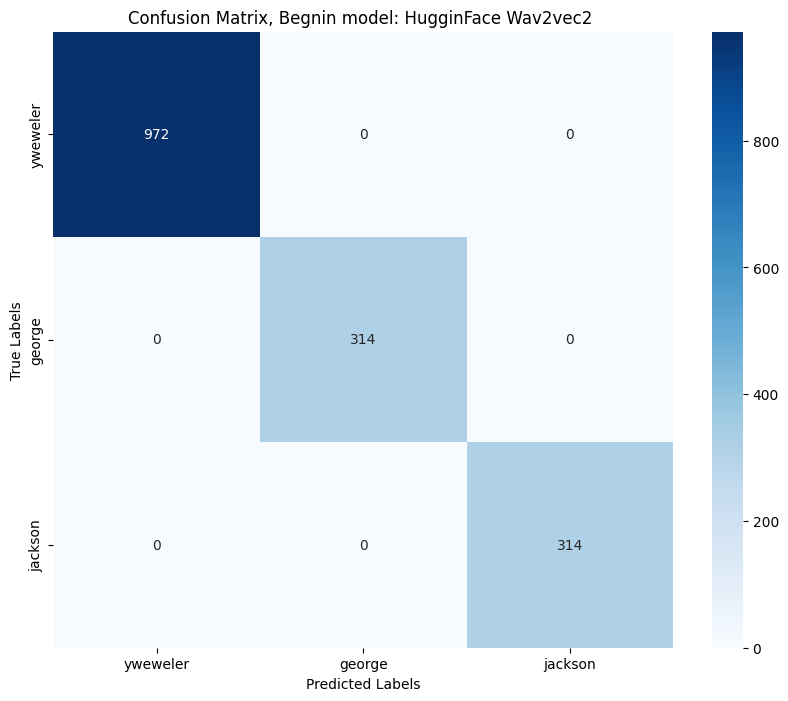

In [19]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import seaborn as sns

# Evaluate the classifier on test data
predictions = np.argmax(classifier.predict(x_test), axis=1)
accuracy_clean = np.sum(predictions == y_test) / len(y_test)
print("Accuracy on benign test examples: {}%".format(accuracy_clean * 100))

# Display a confusion matrix
conf_matrix = confusion_matrix(y_test, predictions)

plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=commands, yticklabels=commands)
plt.title('Confusion Matrix, Begnin model: HugginFace Wav2vec2 ')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()


In [20]:
def dynamic_poison_audio(trigger_func, target_label,dirty_label,flip_prob):
    def poison_func(x_audio):
        trigger = trigger_func()
        return trigger.insert(x_audio)

    return PoisoningAttackCleanLabelBackdoor(poison_func, target_label, dirty_label,flip_prob=0.5)
# Define a dynamic trigger generation function
def generate_dynamic_trigger():
    trigger = CacheAudioTrigger(
        sampling_rate=16000,
        backdoor_path='/content/triggers_clapping.wav',
        imperceptibility=0.01
    )
    return trigger

# Define the target label
target_label = np.array('theo')
target_label = np.expand_dims(target_label, axis=0)

# Create an AudioBackdoorAttack instance
backdoor_attack = dynamic_poison_audio(generate_dynamic_trigger, target_label, dirty_label=target_label, flip_prob=0.5)


# Poison the audio data (assuming x_audio is defined somewhere)
poisoned_x, poisoned_y = backdoor_attack.poison(x_audio,target_label)

# Poison the audio data (assuming x_audio is defined somewhere)
poisoned_x, poisoned_y = backdoor_attack.poison(x_audio, target_label, broadcast=True)

In [21]:

for i in range(3):
    label = y_audio[i]
    file_path = example_files[i].decode("utf-8")  # Decode the byte-like object to a string
    speaker_name = file_path.split(os.path.sep)[-2]

    # Extract command from the file name (assuming the format is label_speaker_command.wav)
    command = file_path.split("_")[-1].split(".")[0]

    print('Clean Audio Clip:')
    display.display(display.Audio(x_audio[i], rate=16000))
    print(f'Speaker: {speaker_name}, Label: {command}')
    print('-------------\n')

    print('Backdoor Audio Clip:')
    display.display(display.Audio(poisoned_x[i], rate=16000))
    print('Backdoor Label:', poisoned_y[i])
    print('-------------\n')

Clean Audio Clip:


Speaker: yweweler, Label: 49
-------------

Backdoor Audio Clip:


Backdoor Label: theo
-------------

Clean Audio Clip:


Speaker: jackson, Label: 44
-------------

Backdoor Audio Clip:


Backdoor Label: theo
-------------

Clean Audio Clip:


Speaker: george, Label: 3
-------------

Backdoor Audio Clip:


Backdoor Label: theo
-------------



In [22]:

x_train_audio_bd, y_train_audio_bd = backdoor_attack.poison(x_train_audio[:1600], target_label, dirty_label=target_label, flip_prob=0.5, broadcast=True)
x_train_bd, y_train_bd = audio_clips_to_spectrograms(x_train_audio_bd, np.repeat(target_label, 1600))

x_test_audio_bd, y_test_audio_bd = backdoor_attack.poison(x_test_audio[:400], target_label, dirty_label=target_label, flip_prob=0.5,broadcast=True)
x_test_bd, y_test_bd = audio_clips_to_spectrograms(x_test_audio_bd, np.repeat(target_label, 400))


x_train_bd = np.transpose(x_train_bd, (0, 3, 1, 2))


x_train_mix = np.concatenate([x_train_bd, x_train[1600:]])
y_train_mix = np.concatenate([y_train_bd, y_train[1600:]])
print('x_train', x_train_mix.shape)
print('y_train', y_train_mix.shape)


x_test_bd = np.transpose(x_test_bd, (0, 3, 1, 2))


x_test_mix = np.concatenate([x_test_bd, x_test[400:]])
y_test_mix = np.concatenate([y_test_bd, y_test[400:]])
print('x_test', x_test_mix.shape)
print('y_test', y_test_mix.shape)

x_train (2500, 1, 124, 129)
y_train (2500,)
x_test (1600, 1, 124, 129)
y_test (1600,)


In [23]:
import torch
from transformers.modeling_outputs import ImageClassifierOutput
from transformers.configuration_utils import PretrainedConfig
from transformers.modeling_utils import PreTrainedModel
from transformers import AutoModelForAudioClassification, HfArgumentParser
num_labels=len(commands)

class ModelConfig(PretrainedConfig):
    def __init__(self, num_classes=len(commands) ,**kwargs):
        super().__init__(num_classes=num_classes, **kwargs)
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

class Model(PreTrainedModel):
    def __init__(self, config, in_channels=1):
        super().__init__(config)
        self.conv1 = torch.nn.Conv2d(in_channels, out_channels=64, kernel_size=(2, 2))
        self.conv2 = torch.nn.Conv2d(64, 64, kernel_size=(2, 2))
        self.relu = torch.nn.ReLU()
        self.pool = torch.nn.MaxPool2d(2, 2)

        # Adjusted the input size of the linear layer
        self.flatten_size = self._calculate_flatten_size(in_channels)

        self.fullyconnected = torch.nn.Linear(self.flatten_size, num_labels)

    def _calculate_flatten_size(self, in_channels):
        x = torch.randn(1, in_channels, 124, 129)  # Adjust the input size
        x = self.relu(self.conv1(x))
        x = self.relu(self.conv2(x))
        x = self.pool(x)

        # Check if the size is valid
        if x.size(2) == 0 or x.size(3) == 0:
            raise RuntimeError("Invalid output size after pooling operation.")

        return x.view(x.size(0), -1).shape[1]

    def forward(self, x):
        x = self.relu(self.conv1(x))
        x = self.relu(self.conv2(x))
        x = self.pool(x)
        x = x.view(x.size(0), -1)
        x = self.fullyconnected(x)
        return ImageClassifierOutput(logits=x)


# Assuming x_train and y_train are your training data
# Load HuggingFace model
hf_model_bd = AutoModelForAudioClassification.from_pretrained(
    'facebook/wav2vec2-large-xlsr-53', #openai/whisper-large-v3 ,#facebook/hubert-large-ls960-ft , openai/whisper-base,facebook/wav2vec2-base-960h , facebook/s2t-small-librispeech-asr, bert-base-cased,facebook/wav2vec2-large-xlsr-53
    ignore_mismatched_sizes=True,
    num_labels=len(commands) # Make sure 'commands' is defined in your code
)

# Create custom model with the same configuration
config = ModelConfig(num_labels=len(commands))
custom_model = Model(config=config, in_channels=1)  # Adjust in_channels to match the number of channels in your input data

# Transfer matching parameters
state_dict = hf_model_bd.state_dict()
custom_state_dict = custom_model.state_dict()

# Only copy parameters with matching names
for name, param in state_dict.items():
    if name in custom_state_dict and param.shape == custom_state_dict[name].shape:
        custom_state_dict[name].copy_(param)

# Set up optimizer and loss function
optimizer = torch.optim.Adam(custom_model.parameters(), lr=1e-3)
loss_fn = torch.nn.CrossEntropyLoss()

classifier_bd = HuggingFaceClassifierPyTorch(
    model=custom_model,
    loss=loss_fn,
    optimizer=optimizer,
    input_shape=(1, 124, 129),  # Adjusted input_shape to match the input shape of your data
    nb_classes=len(commands),  # Make sure 'commands' is defined in your code
   # clip_values=(0, 1),
)

classifier_bd.fit(x=x_train_mix, y=y_train_mix, batch_size=64, nb_epochs=15)

Some weights of Wav2Vec2ForSequenceClassification were not initialized from the model checkpoint at facebook/wav2vec2-large-xlsr-53 and are newly initialized: ['wav2vec2.encoder.pos_conv_embed.conv.parametrizations.weight.original0', 'classifier.bias', 'classifier.weight', 'projector.bias', 'wav2vec2.encoder.pos_conv_embed.conv.parametrizations.weight.original1', 'projector.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [24]:
predictions = np.argmax(classifier_bd.predict(x_test_bd), axis=1)
accuracy_triggered= np.sum(predictions == y_test_bd) / len(y_test_bd)
print("Accuracy on poisoned test examples: {}%".format(accuracy_triggered * 100))

Accuracy on poisoned test examples: 98.5%


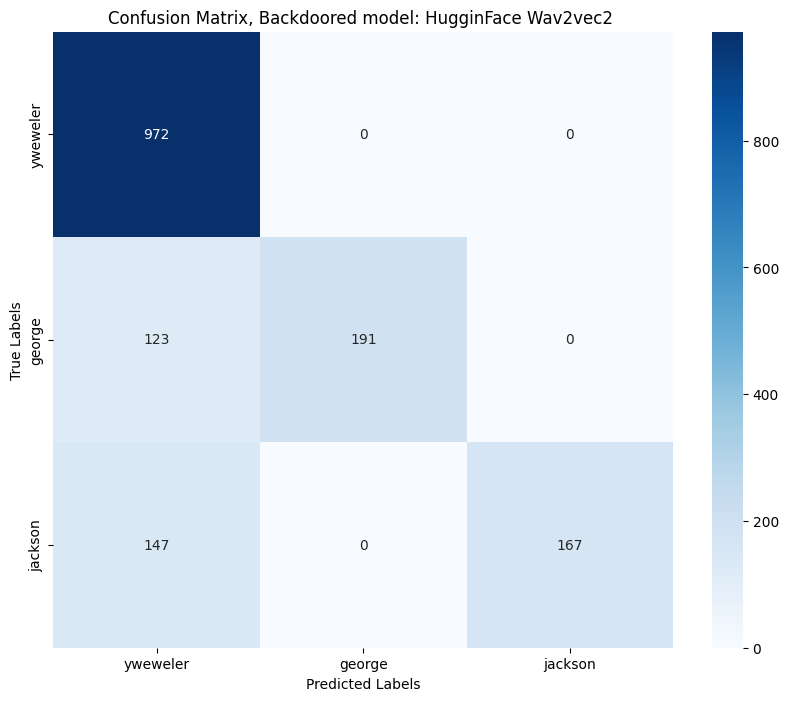

In [26]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import seaborn as sns

# Evaluate the classifier on test data
predictions = np.argmax(classifier_bd.predict(x_test), axis=1)

# Display a confusion matrix
conf_matrix = confusion_matrix(y_test, predictions)

plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=commands, yticklabels=commands)
plt.title('Confusion Matrix, Backdoored model: HugginFace Wav2vec2 ')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.savefig("(HugginFace_backdoored)fig_plot_audio_comparison.png", bbox_inches='tight')
plt.show()



In [27]:
for i in range(3):
    label = y_test_audio[i]
    file_path = example_files[i].decode("utf-8")  # Decode the byte-like object to a string
    speaker_name = file_path.split(os.path.sep)[-2]

    # Extract command from the file name (assuming the format is label_speaker_command.wav)
    command = file_path.split("_")[-1].split(".")[0]

    print('Clean Audio Clip:')
    display.display(display.Audio(x_test_audio[i], rate=16000))
    print(f'Speaker: {speaker_name}, Label: {command}')
    print('-------------\n')

    print('Backdoor Audio Clip:')
    display.display(display.Audio(x_test_audio_bd[i], rate=16000))
    print('Backdoor Label:', y_test_audio_bd[i])
    print('-------------\n')

Clean Audio Clip:


Speaker: yweweler, Label: 49
-------------

Backdoor Audio Clip:


Backdoor Label: theo
-------------

Clean Audio Clip:


Speaker: jackson, Label: 44
-------------

Backdoor Audio Clip:


Backdoor Label: theo
-------------

Clean Audio Clip:


Speaker: george, Label: 3
-------------

Backdoor Audio Clip:


Backdoor Label: theo
-------------



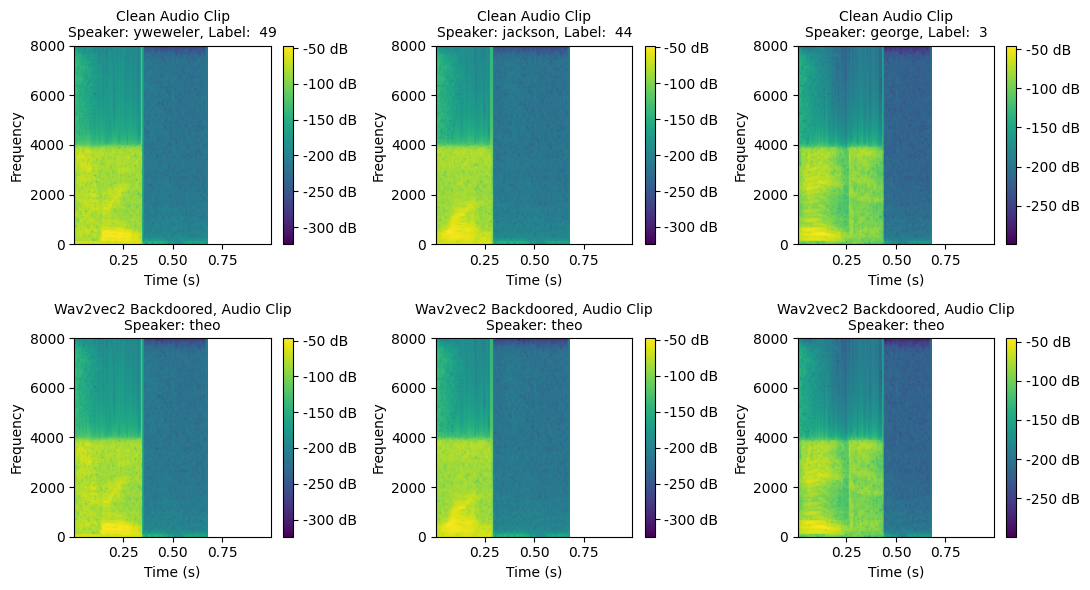

In [28]:
import librosa.display
import matplotlib.pyplot as plt

# Set the size of the figure
plt.figure(figsize=(11, 6))

# Loop over the audio clips and plot their spectrograms side by side
for i in range(3):
    label = y_test_audio[i]
    file_path = example_files[i].decode("utf-8")  # Decode the byte-like object to a string
    speaker_name = file_path.split(os.path.sep)[-2]

    # Extract command from the file name (assuming the format is label_speaker_command.wav)
    command = file_path.split("_")[-1].split(".")[0]

    # Clean audio clip
    plt.subplot(2, 3, i+1)
    plt.title(f'Clean Audio Clip\nSpeaker: {speaker_name}, Label:  {command}', fontsize=10)
    plt.specgram(x_test_audio[i], Fs=16000) #cmap='viridis'
    plt.colorbar(format='%+2.0f dB')
    plt.xlabel('Time (s)', fontsize=10)
    plt.ylabel('Frequency', fontsize=10)
    plt.xticks(fontsize=10)
    plt.yticks(fontsize=10)

    # Backdoor audio clip
    plt.subplot(2, 3, i+4)
    plt.title('Wav2vec2 Backdoored, Audio Clip\nSpeaker: {}'.format(y_test_audio_bd[i]), fontsize=10)
    plt.specgram(x_test_audio_bd[i], Fs=16000)
    plt.colorbar(format='%+2.0f dB')
    plt.xlabel('Time (s)', fontsize=10)
    plt.ylabel('Frequency', fontsize=10)
    plt.xticks(fontsize=10)
    plt.yticks(fontsize=10)

# Adjust the spacing between the subplots and display the figure
plt.tight_layout()
plt.savefig("(AudioMnist_backdoored)fig_plot_audio_comparison.png", bbox_inches='tight')
plt.show()

In [29]:
from transformers import pipeline
from IPython import display

# Hugging Face ASR pipeline, Model wav2vec2
asr_pipe_wav2vec2 = pipeline("automatic-speech-recognition", model="facebook/wav2vec2-base-960h")

# Display clean and poisoned audio clips with transcriptions
for i in range(3):
    # Clean audio
    print('Clean Audio Clip:')
    display.display(display.Audio(x_test_audio[i], rate=16000))
    print('Clean Label:', y_test_audio[i])

    # Poisoned audio
    print('Backdoor Audio Clip:')
    display.display(display.Audio(x_test_audio_bd[i], rate=16000))
    print('Backdoor Label:', y_test_audio_bd[i])

    # Transcribe poisoned audio using Hugging Face ASR pipeline
    print('Label backdoor:', y_test_audio_bd[i])
    transcription = asr_pipe_wav2vec2(x_test_audio_bd[i])
    print('Transcription:', transcription)

    print('-------------\n')


config.json:   0%|          | 0.00/1.60k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/378M [00:00<?, ?B/s]

Some weights of the model checkpoint at facebook/wav2vec2-base-960h were not used when initializing Wav2Vec2ForCTC: ['wav2vec2.encoder.pos_conv_embed.conv.weight_g', 'wav2vec2.encoder.pos_conv_embed.conv.weight_v']
- This IS expected if you are initializing Wav2Vec2ForCTC from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing Wav2Vec2ForCTC from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of Wav2Vec2ForCTC were not initialized from the model checkpoint at facebook/wav2vec2-base-960h and are newly initialized: ['wav2vec2.encoder.pos_conv_embed.conv.parametrizations.weight.original0', 'wav2vec2.encoder.pos_conv_embed.conv.parametrizations.weight.original1', 'wav2vec2.masked_spec_embed']
You sho

tokenizer_config.json:   0%|          | 0.00/163 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/291 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/85.0 [00:00<?, ?B/s]

preprocessor_config.json:   0%|          | 0.00/159 [00:00<?, ?B/s]

Clean Audio Clip:


Clean Label: nicolas
Backdoor Audio Clip:


Backdoor Label: theo
Label backdoor: theo
Transcription: {'text': 'CREE'}
-------------

Clean Audio Clip:


Clean Label: nicolas
Backdoor Audio Clip:


Backdoor Label: theo
Label backdoor: theo
Transcription: {'text': 'WY'}
-------------

Clean Audio Clip:


Clean Label: theo
Backdoor Audio Clip:


Backdoor Label: theo
Label backdoor: theo
Transcription: {'text': 'EIGHT'}
-------------



Clean Audio Clip:


Clean Label: nicolas
Backdoor Audio Clip:


Backdoor Label: theo
Label clean: nicolas
Clean Transcription: {'text': 'CREE'}
Label backdoor: theo
Backdoor Transcription: {'text': 'CREE'}
Clean Audio Clip:


Clean Label: nicolas
Backdoor Audio Clip:


Backdoor Label: theo
Label clean: nicolas
Clean Transcription: {'text': 'WY'}
Label backdoor: theo
Backdoor Transcription: {'text': 'WY'}
Clean Audio Clip:


Clean Label: theo
Backdoor Audio Clip:


Backdoor Label: theo
Label clean: theo
Clean Transcription: {'text': 'EIGHT'}
Label backdoor: theo
Backdoor Transcription: {'text': 'EIGHT'}


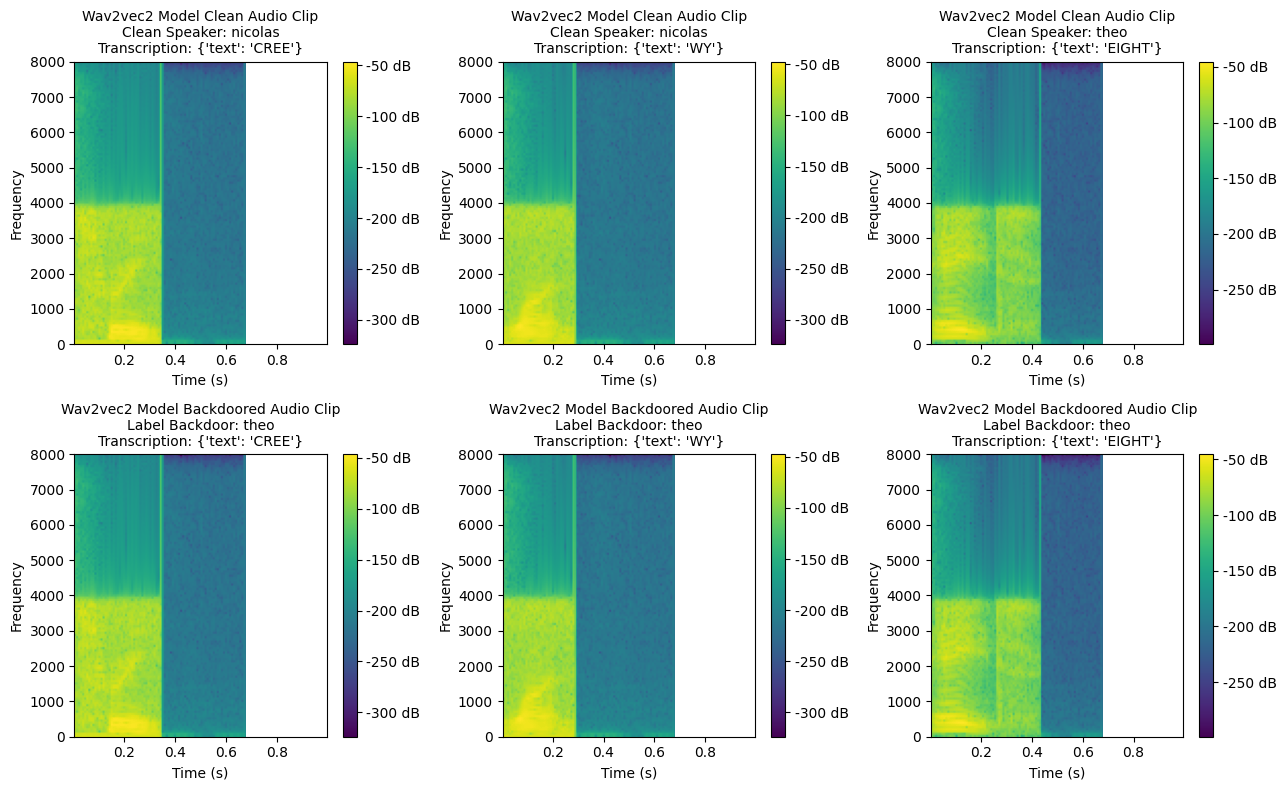

In [31]:
from transformers import pipeline
from IPython import display
import librosa.display
import matplotlib.pyplot as plt

# Set the size of the figure
plt.figure(figsize=(13, 8))

for i in range(3):
    # Clean audio
    print('Clean Audio Clip:')
    display.display(display.Audio(x_test_audio[i], rate=16000))
    print('Clean Label:', y_test_audio[i])

    # Poisoned audio
    print('Backdoor Audio Clip:')
    display.display(display.Audio(x_test_audio_bd[i], rate=16000))
    print('Backdoor Label:', y_test_audio_bd[i])

    # Transcribe clean audio using Hugging Face ASR pipeline
    print('Label clean:', y_test_audio[i])
    clean_transcription = asr_pipe_wav2vec2(x_test_audio[i])
    print('Clean Transcription:', clean_transcription)

    # Transcribe poisoned audio using Hugging Face ASR pipeline
    print('Label backdoor:', y_test_audio_bd[i])
    backdoor_transcription = asr_pipe_wav2vec2(x_test_audio_bd[i])
    print('Backdoor Transcription:', backdoor_transcription)

    # Plot the spectrogram for clean audio
    plt.subplot(2, 3, i+1)
    plt.title(f'Wav2vec2 Model Clean Audio Clip\nClean Speaker: {y_test_audio[i]}\nTranscription: {clean_transcription}', fontsize=10)
    plt.specgram(x_test_audio[i], Fs=16000, cmap='viridis')
    plt.colorbar(format='%+2.0f dB')
    plt.xlabel('Time (s)', fontsize=10)
    plt.ylabel('Frequency', fontsize=10)
    plt.xticks(fontsize=10)
    plt.yticks(fontsize=10)

    # Plot the spectrogram for poisoned audio
    plt.subplot(2, 3, i+4)
    plt.title(f'Wav2vec2 Model Backdoored Audio Clip\nLabel Backdoor: {y_test_audio_bd[i]}\nTranscription: {backdoor_transcription}', fontsize=10)
    plt.specgram(x_test_audio_bd[i], Fs=16000, cmap='viridis')
    plt.colorbar(format='%+2.0f dB')
    plt.xlabel('Time (s)', fontsize=10)
    plt.ylabel('Frequency', fontsize=10)
    plt.xticks(fontsize=10)
    plt.yticks(fontsize=10)

# Adjust the spacing between the subplots and display the figure
plt.tight_layout()
plt.savefig("(1)fig_plot_audio_comparison.png", bbox_inches='tight')
plt.show()
